# Exploration 11. 어제 오른 내 주식, 과연 내일은?

# 프로젝트 : 주식 예측에 도전해 보자

### 평가 루브릭

(1) 시계열의 안정성이 충분히 확인되었는가?  
-> 플로팅과 adfuller 메소드가 모두 적절히 사용되었음  


(2) ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?  
-> p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨


(3) 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?  
-> 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨

## STEP 1 : 시계열 데이터 준비

여러 종류의 칼럼 중 "종가(Close)"만 사용

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore') #경고 무시

In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행

결측치는 양쪽 값을 이용한 보간을 하여 처리한다

In [3]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

로그 변환을 해준다

In [4]:
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석

정성적 그래프 분석 함수 정의

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

정량적 Augmented Dicky-Fuller Test 함수 정의

In [6]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

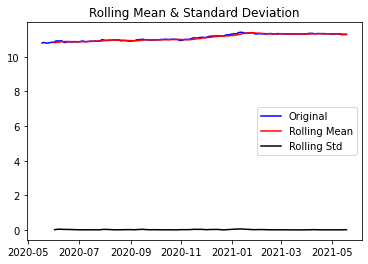

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


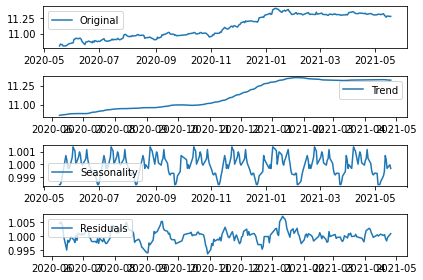

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Residual 안정성 확인

In [8]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성

학습, 테스트 데이터셋 분리

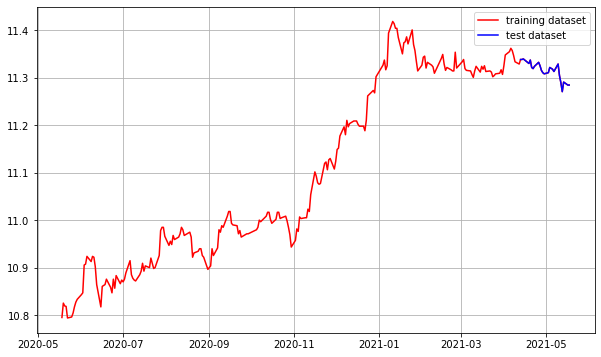

In [9]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

ACF, PACF 그려보고 p와 q 구해야함

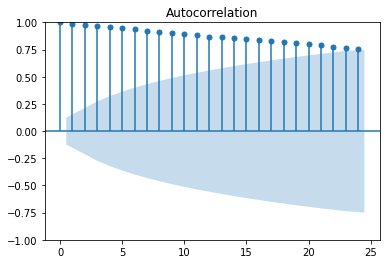

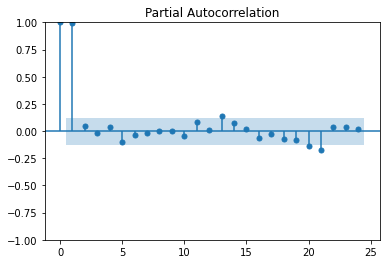

In [10]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
#plot_acf(pd.Series(ts_log).diff(1).dropna())
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

차분 안정성 확인하여 d를 구함

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


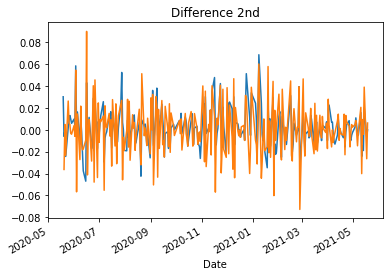

In [11]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련

In [12]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 17 Feb 2022   AIC                          -1156.722
Time:                        14:29:23   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


모델 테스트 및 플로팅

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


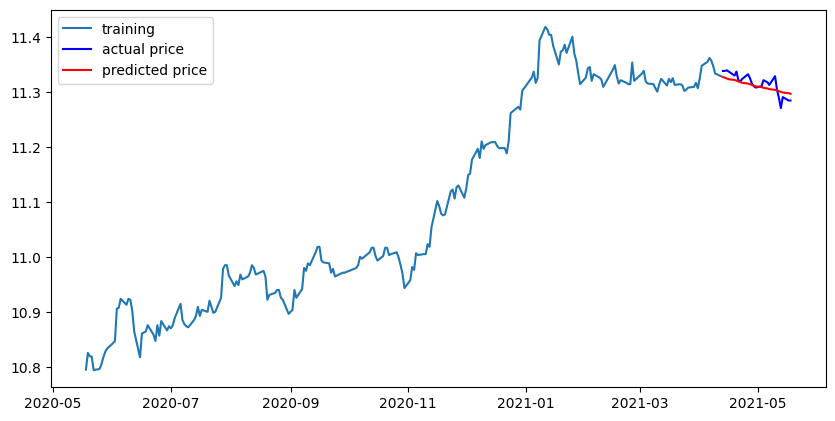

In [13]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

최종 예측 모델 정확도 측정(MAPE)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


## STEP 7 : 다른 주식 종목 예측해 보기

---

#### Netflix

In [15]:
dataset_NFLX_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NFLX.csv'
df_NFLX = pd.read_csv(dataset_NFLX_filepath, index_col='Date', parse_dates=True)
ts_NFLX = df_NFLX['Close']

ts_NFLX.head()

Date
2021-02-10    563.590027
2021-02-11    557.590027
2021-02-12    556.520020
2021-02-16    557.280029
2021-02-17    551.340027
Name: Close, dtype: float64

In [16]:
# 결측치 처리
ts_NFLX = ts_NFLX.interpolate(method='time')
ts_NFLX[ts_NFLX.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [17]:
ts_NFLX_log = np.log(ts_NFLX)

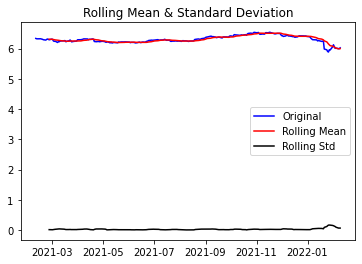

Results of Dickey-Fuller Test:
Test Statistic                  -1.517797
p-value                          0.524690
#Lags Used                       9.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


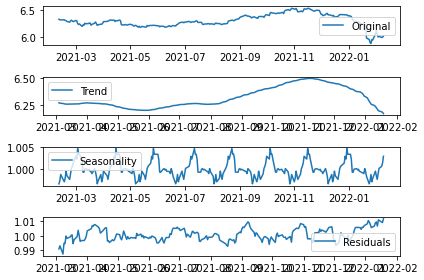

In [18]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_NFLX_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_NFLX_log)

#시계열 분해 (Time Series Decomposition)
decomposition_NFLX = seasonal_decompose(ts_NFLX_log, model='multiplicative', period = 30) 

trend_NFLX = decomposition_NFLX.trend
seasonal_NFLX = decomposition_NFLX.seasonal
residual_NFLX = decomposition_NFLX.resid

plt.subplot(411)
plt.plot(ts_NFLX_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_NFLX, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_NFLX,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_NFLX, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [19]:
# Residual 안정성 확인
residual_NFLX.dropna(inplace=True)
augmented_dickey_fuller_test(residual_NFLX)

Results of Dickey-Fuller Test:
Test Statistic                  -4.235971
p-value                          0.000572
#Lags Used                       0.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


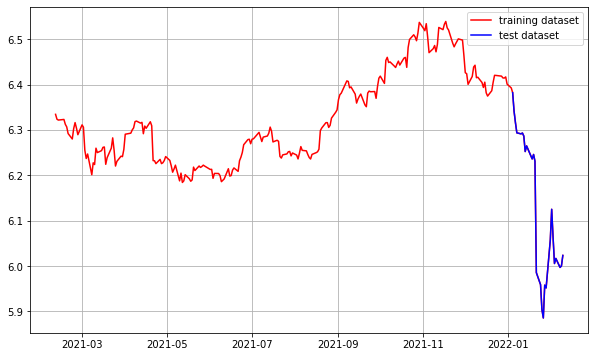

In [20]:
train_data_NFLX, test_data_NFLX = ts_NFLX_log[:int(len(ts_NFLX_log)*0.9)], ts_NFLX_log[int(len(ts_NFLX_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_NFLX_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_NFLX, c='b', label='test dataset')
plt.legend()

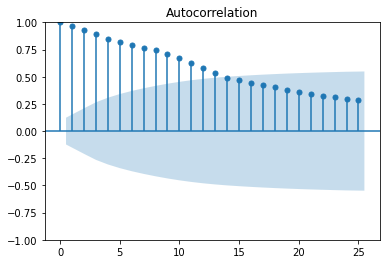

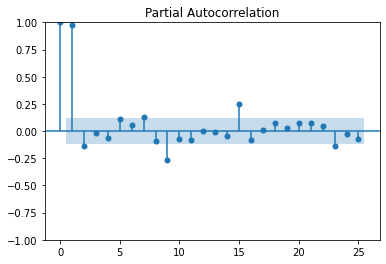

In [21]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_NFLX_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_NFLX_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF는 조금씩 줄어들고, PACF는 1이후로 0의 값을 보인다.  
AR(1) 모델로 추정

Results of Dickey-Fuller Test:
Test Statistic                  -4.377347
p-value                          0.000325
#Lags Used                       8.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.167270e+01
p-value                        1.818679e-21
#Lags Used                     7.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


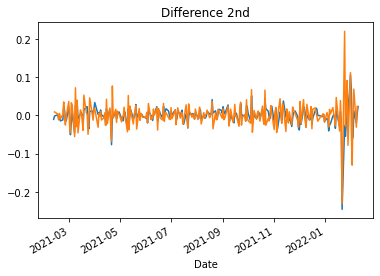

In [22]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1_NFLX = ts_NFLX_log.diff(periods=1).iloc[1:]
diff_1_NFLX.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_NFLX)

# 혹시 필요한 경우 2차 차분 구하기
diff_2_NFLX = diff_1_NFLX.diff(periods=1).iloc[1:]
diff_2_NFLX.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2_NFLX)

1차 미분도 안정적이긴 하지만 2차 미분에서 확실히 안정된 모습을 보인다.

In [23]:
# Build Model
model_NFLX = ARIMA(train_data_NFLX, order=(1, 2, 0))  
fitted_m_NFLX = model_NFLX.fit() 

print(fitted_m_NFLX.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 552.236
Date:                Thu, 17 Feb 2022   AIC                          -1100.472
Time:                        14:29:25   BIC                          -1093.640
Sample:                             0   HQIC                         -1097.715
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4319      0.053     -8.204      0.000      -0.535      -0.329
sigma2         0.0004   3.55e-05     12.156      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   7.06   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


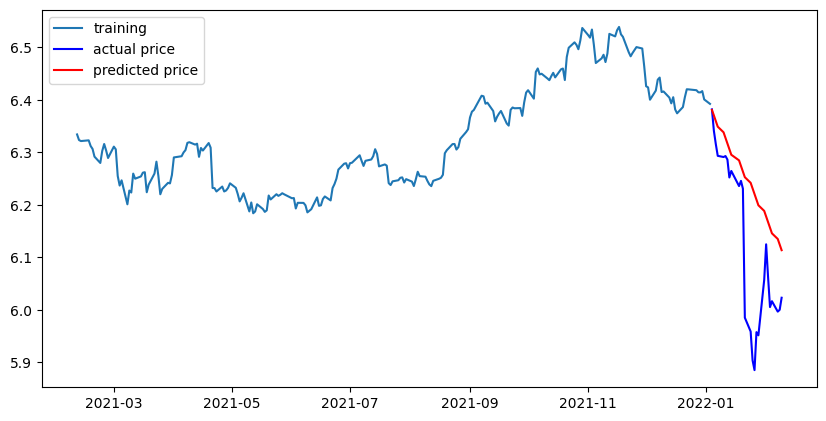

In [24]:
# Forecast : 결과가 fc에 담깁니다. 
fc_NFLX = fitted_m_NFLX.forecast(len(test_data_NFLX), alpha=0.05)  # 95% conf
fc_NFLX = np.array(fc_NFLX)
# Make as pandas series
fc_series_NFLX = pd.Series(fc_NFLX, index=test_data_NFLX.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_NFLX, label='training')
plt.plot(test_data_NFLX, c='b', label='actual price')
plt.plot(fc_series_NFLX, c='r',label='predicted price')
plt.legend()
plt.show()

세세하게 예측하지는 못했지만 비슷한 양상으로 예측한 것을 볼 수 있다.

In [25]:
mse_NFLX = mean_squared_error(np.exp(test_data_NFLX), np.exp(fc_NFLX))
print('MSE: ', mse_NFLX)

mae_NFLX = mean_absolute_error(np.exp(test_data_NFLX), np.exp(fc_NFLX))
print('MAE: ', mae_NFLX)

rmse_NFLX = math.sqrt(mean_squared_error(np.exp(test_data_NFLX), np.exp(fc_NFLX)))
print('RMSE: ', rmse_NFLX)

mape_NFLX = np.mean(np.abs(np.exp(fc_NFLX) - np.exp(test_data_NFLX))/np.abs(np.exp(test_data_NFLX)))
print('MAPE: {:.2f}%'.format(mape_NFLX*100))

MSE:  4735.938608529775
MAE:  53.779014756308484
RMSE:  68.81815609655474
MAPE: 13.14%


그래프 양상은 비슷하게 나오긴 했지만, 디테일한 부분에서 차이가 있어 MAPE는 약 13%로 만족스럽진 않다.

---

#### Naver

In [26]:
dataset_NAVER_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035420.KS_NAVER.csv'
df_NAVER = pd.read_csv(dataset_NAVER_filepath, index_col='Date', parse_dates=True)
ts_NAVER = df_NAVER['Close']

ts_NAVER.head()

Date
2021-02-10    366500.0
2021-02-15    385500.0
2021-02-16    394000.0
2021-02-17    392000.0
2021-02-18    388000.0
Name: Close, dtype: float64

In [27]:
# 결측치 처리
ts_NAVER = ts_NAVER.interpolate(method='time')
ts_NAVER[ts_NAVER.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [28]:
ts_NAVER_log = np.log(ts_NAVER)

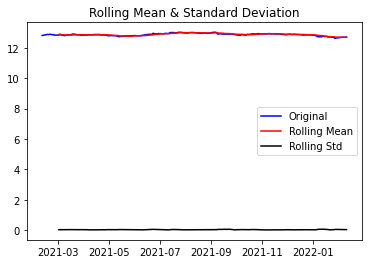

Results of Dickey-Fuller Test:
Test Statistic                  -1.166783
p-value                          0.687719
#Lags Used                       2.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


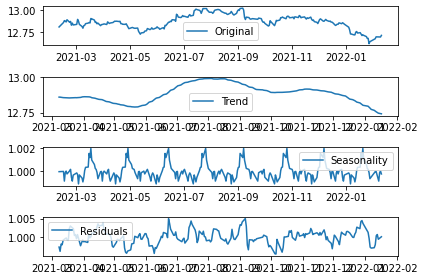

In [29]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_NAVER_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_NAVER_log)

#시계열 분해 (Time Series Decomposition)
decomposition_NAVER = seasonal_decompose(ts_NAVER_log, model='multiplicative', period = 30) 

trend_NAVER = decomposition_NAVER.trend
seasonal_NAVER = decomposition_NAVER.seasonal
residual_NAVER = decomposition_NAVER.resid

plt.subplot(411)
plt.plot(ts_NAVER_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_NAVER, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_NAVER,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_NAVER, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [30]:
# Residual 안정성 확인
residual_NAVER.dropna(inplace=True)
augmented_dickey_fuller_test(residual_NAVER)

Results of Dickey-Fuller Test:
Test Statistic                -5.829930e+00
p-value                        3.997177e-07
#Lags Used                     4.000000e+00
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64


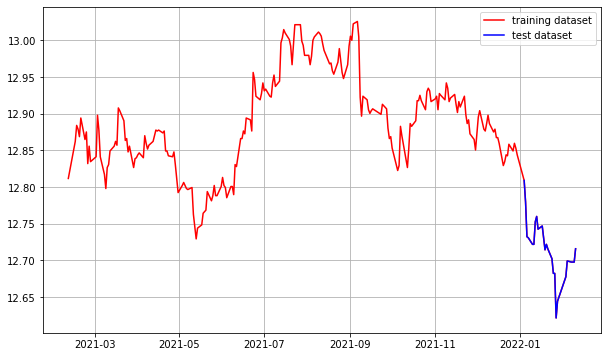

In [31]:
train_data_NAVER, test_data_NAVER = ts_NAVER_log[:int(len(ts_NAVER_log)*0.9)], ts_NAVER_log[int(len(ts_NAVER_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_NAVER_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_NAVER, c='b', label='test dataset')
plt.legend()

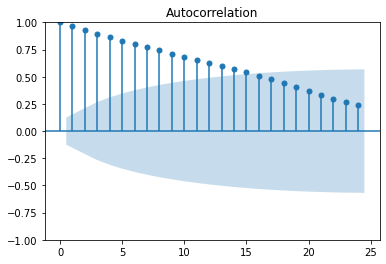

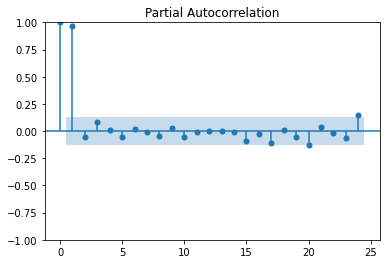

In [32]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_NAVER_log)   # ACF : Autocorrelation 그래프 그리기
#plot_acf(pd.Series(ts_NAVER_log).diff(2).dropna())
plot_pacf(ts_NAVER_log)  # PACF : Partial Autocorrelation 그래프 그리기
#plot_pacf(pd.Series(ts_NAVER_log).diff(2).dropna())
plt.show()

ACF는 조금씩 줄어들고, PACF는 1이후로 0의 값을 보인다.
AR(1) 모델로 추정

Results of Dickey-Fuller Test:
Test Statistic                -1.210974e+01
p-value                        1.931728e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.989003e+00
p-value                        2.503747e-12
#Lags Used                     1.400000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


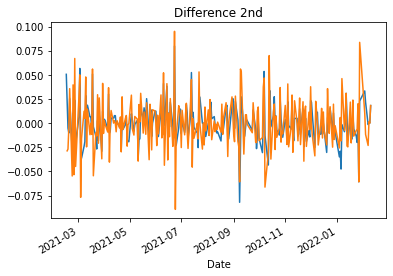

In [33]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1_NAVER = ts_NAVER_log.diff(periods=1).iloc[1:]
diff_1_NAVER.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_NAVER)

# 혹시 필요한 경우 2차 차분 구하기
diff_2_NAVER = diff_1_NAVER.diff(periods=1).iloc[1:]
diff_2_NAVER.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2_NAVER)

1차 미분도 안정적이지만 2차 미분에서 안정된 모습을 보인다.  
더 짧은 추세를 참고하기 위해 2차 미분으로 선택

In [34]:
# Build Model
model_NAVER = ARIMA(train_data_NAVER, order=(1, 2, 0))  
fitted_m_NAVER = model_NAVER.fit() 

print(fitted_m_NAVER.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 506.632
Date:                Thu, 17 Feb 2022   AIC                          -1009.264
Time:                        14:29:26   BIC                          -1002.486
Sample:                             0   HQIC                         -1006.526
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4238      0.045     -9.519      0.000      -0.511      -0.337
sigma2         0.0006   4.47e-05     12.792      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   5.05   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


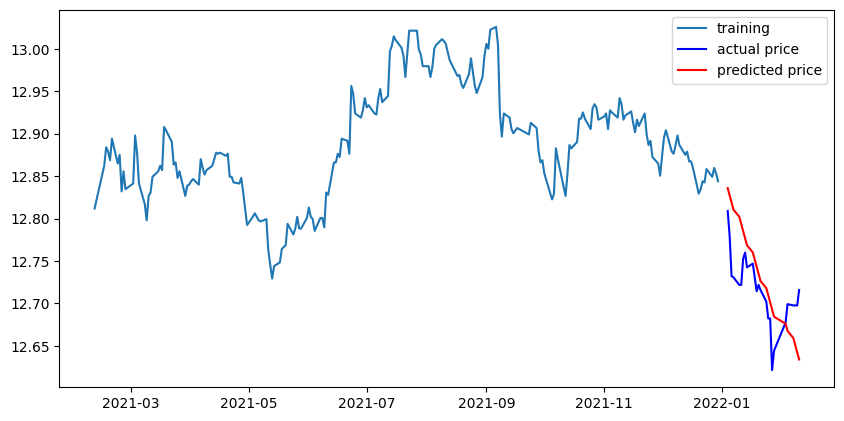

In [35]:
# Forecast : 결과가 fc에 담깁니다. 
fc_NAVER = fitted_m_NAVER.forecast(len(test_data_NAVER), alpha=0.05)  # 95% conf
fc_NAVER = np.array(fc_NAVER)
# Make as pandas series
fc_series_NAVER = pd.Series(fc_NAVER, index=test_data_NAVER.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_NAVER, label='training')
plt.plot(test_data_NAVER, c='b', label='actual price')
plt.plot(fc_series_NAVER, c='r',label='predicted price')
plt.legend()
plt.show()

상당히 의미있는 예측 그래프가 생성되었다.  
마지막의 상승은 예측하지 못했지만 양상 자체는 알맞게 예측된 모습이다.

In [36]:
mse_NAVER = mean_squared_error(np.exp(test_data_NAVER), np.exp(fc_NAVER))
print('MSE: ', mse_NAVER)

mae_NAVER = mean_absolute_error(np.exp(test_data_NAVER), np.exp(fc_NAVER))
print('MAE: ', mae_NAVER)

rmse_NAVER = math.sqrt(mean_squared_error(np.exp(test_data_NAVER), np.exp(fc_NAVER)))
print('RMSE: ', rmse_NAVER)

mape_NAVER = np.mean(np.abs(np.exp(fc_NAVER) - np.exp(test_data_NAVER))/np.abs(np.exp(test_data_NAVER)))
print('MAPE: {:.2f}%'.format(mape_NAVER*100))

MSE:  250571720.0676567
MAE:  13280.105906797986
RMSE:  15829.45735228017
MAPE: 3.99%


그래프에서처럼 MAPE로 약 4%로 아주 만족스러운 결과를 보여준다.

---

#### Kakao

In [37]:
dataset_KAKAO_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035720.KS_KAKAO.csv'
df_KAKAO = pd.read_csv(dataset_KAKAO_filepath, index_col='Date', parse_dates=True)
ts_KAKAO = df_KAKAO['Close']

ts_KAKAO.head()

Date
2021-02-10     97900.0
2021-02-15    100400.0
2021-02-16    102800.0
2021-02-17    101800.0
2021-02-18    100200.0
Name: Close, dtype: float64

In [38]:
# 결측치 처리
ts_KAKAO = ts_KAKAO.interpolate(method='time')
ts_KAKAO[ts_KAKAO.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [39]:
ts_KAKAO_log = np.log(ts_KAKAO)

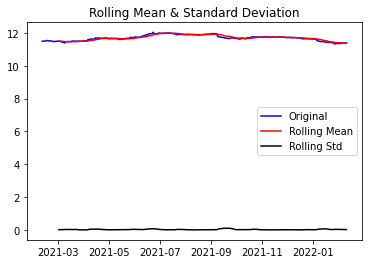

Results of Dickey-Fuller Test:
Test Statistic                  -1.339107
p-value                          0.611096
#Lags Used                       7.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


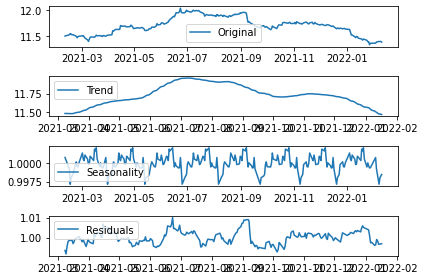

In [40]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_KAKAO_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_KAKAO_log)

#시계열 분해 (Time Series Decomposition)
decomposition_KAKAO = seasonal_decompose(ts_KAKAO_log, model='multiplicative', period = 30) 

trend_KAKAO = decomposition_KAKAO.trend
seasonal_KAKAO = decomposition_KAKAO.seasonal
residual_KAKAO = decomposition_KAKAO.resid

plt.subplot(411)
plt.plot(ts_KAKAO_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_KAKAO, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_KAKAO,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_KAKAO, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [41]:
# Residual 안정성 확인
residual_KAKAO.dropna(inplace=True)
augmented_dickey_fuller_test(residual_KAKAO)

Results of Dickey-Fuller Test:
Test Statistic                  -4.559906
p-value                          0.000153
#Lags Used                       5.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


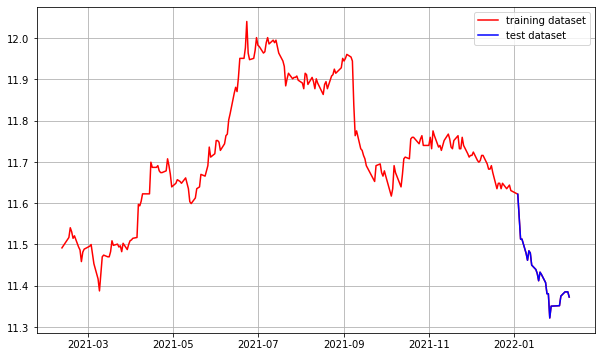

In [42]:
train_data_KAKAO, test_data_KAKAO = ts_KAKAO_log[:int(len(ts_KAKAO_log)*0.9)], ts_KAKAO_log[int(len(ts_KAKAO_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_KAKAO_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_KAKAO, c='b', label='test dataset')
plt.legend()

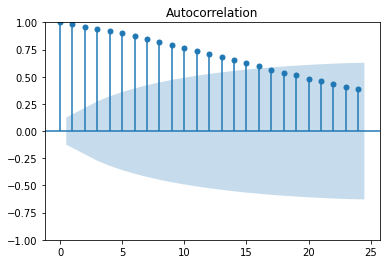

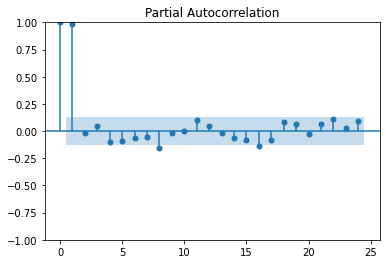

In [43]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_KAKAO_log)   # ACF : Autocorrelation 그래프 그리기
#plot_acf(pd.Series(ts_KAKAO_log).diff(1).dropna())
plot_pacf(ts_KAKAO_log)  # PACF : Partial Autocorrelation 그래프 그리기
#plot_pacf(pd.Series(ts_KAKAO_log).diff(1).dropna())
plt.show()

역시나 ACF는 조금씩 줄어들고, PACF는 1이후로 0의 값을 보인다. AR(1) 모델로 추정

Results of Dickey-Fuller Test:
Test Statistic                -7.888739e+00
p-value                        4.495774e-12
#Lags Used                     2.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.071637e+01
p-value                        3.233677e-19
#Lags Used                     6.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


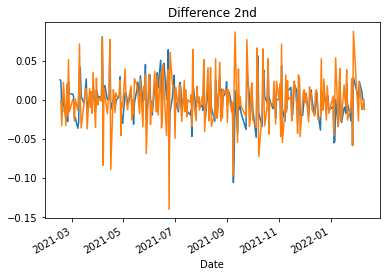

In [44]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1_KAKAO = ts_KAKAO_log.diff(periods=1).iloc[1:]
diff_1_KAKAO.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_KAKAO)

# 혹시 필요한 경우 2차 차분 구하기
diff_2_KAKAO = diff_1_KAKAO.diff(periods=1).iloc[1:]
diff_2_KAKAO.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2_KAKAO)

1차, 2차 미분 모두 안정된 모습을 보이지만 더 좁은 구간을 참고하기 위해 2차 미분 선택

In [45]:
# Build Model
model_KAKAO = ARIMA(train_data_KAKAO, order=(1, 2, 0))  
fitted_m_KAKAO = model_KAKAO.fit() 

print(fitted_m_KAKAO.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 465.398
Date:                Thu, 17 Feb 2022   AIC                           -926.795
Time:                        14:29:28   BIC                           -920.017
Sample:                             0   HQIC                          -924.058
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4154      0.059     -7.024      0.000      -0.531      -0.300
sigma2         0.0008   5.75e-05     14.516      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   7.63   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


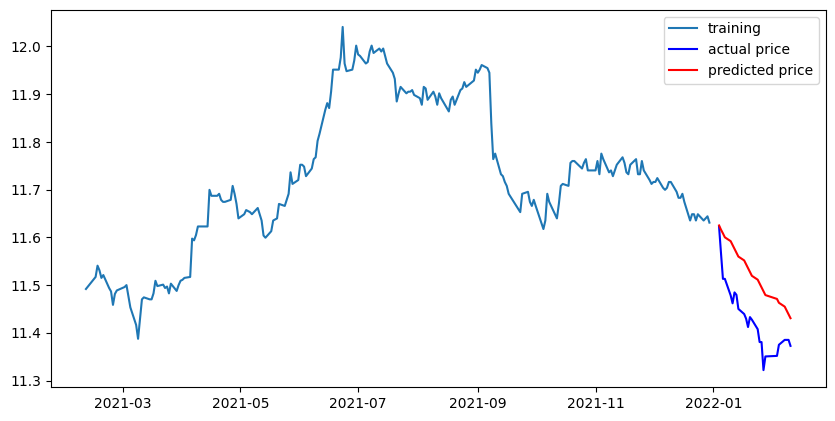

In [46]:
# Forecast : 결과가 fc에 담깁니다. 
fc_KAKAO = fitted_m_KAKAO.forecast(len(test_data_KAKAO), alpha=0.05)  # 95% conf
fc_KAKAO = np.array(fc_KAKAO)
# Make as pandas series
fc_series_KAKAO = pd.Series(fc_KAKAO, index=test_data_KAKAO.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_KAKAO, label='training')
plt.plot(test_data_KAKAO, c='b', label='actual price')
plt.plot(fc_series_KAKAO, c='r',label='predicted price')
plt.legend()
plt.show()

완전히 fit하진 않지만 충분히 예상가능한 예측값을 보여줬다.

In [47]:
mse_KAKAO = mean_squared_error(np.exp(test_data_KAKAO), np.exp(fc_KAKAO))
print('MSE: ', mse_KAKAO)

mae_KAKAO = mean_absolute_error(np.exp(test_data_KAKAO), np.exp(fc_KAKAO))
print('MAE: ', mae_KAKAO)

rmse_KAKAO = math.sqrt(mean_squared_error(np.exp(test_data_KAKAO), np.exp(fc_KAKAO)))
print('RMSE: ', rmse_KAKAO)

mape_KAKAO = np.mean(np.abs(np.exp(fc_KAKAO) - np.exp(test_data_KAKAO))/np.abs(np.exp(test_data_KAKAO)))
print('MAPE: {:.2f}%'.format(mape_KAKAO*100))

MSE:  93180276.75807367
MAE:  9158.674829052265
RMSE:  9652.993150213755
MAPE: 10.05%


그래프에서 보이듯 우하향하는 양상은 같지만 실제 데이터와의 간격이 꽤 있기에 MAPE는 약 10%로 조금 높게 나왔다.

---

#### POSCO

In [48]:
dataset_POSCO_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005490.KS_POSCO.csv'
df_POSCO = pd.read_csv(dataset_POSCO_filepath, index_col='Date', parse_dates=True)
ts_POSCO = df_POSCO['Close']

ts_POSCO.head()

Date
2021-02-17    270500.0
2021-02-18    265000.0
2021-02-19    263500.0
2021-02-22    268000.0
2021-02-23    279500.0
Name: Close, dtype: float64

In [49]:
# 결측치 처리
ts_POSCO = ts_POSCO.interpolate(method='time')
ts_POSCO[ts_POSCO.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [50]:
ts_POSCO_log = np.log(ts_POSCO)

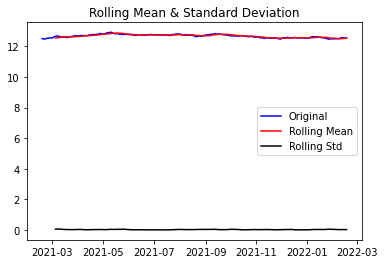

Results of Dickey-Fuller Test:
Test Statistic                  -1.818719
p-value                          0.371208
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


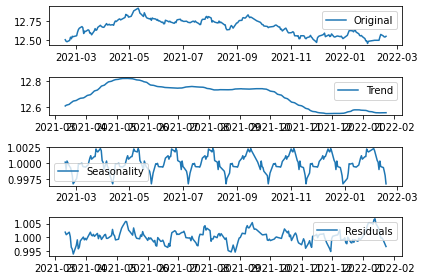

In [51]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_POSCO_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_POSCO_log)

#시계열 분해 (Time Series Decomposition)
decomposition_POSCO = seasonal_decompose(ts_POSCO_log, model='multiplicative', period = 30) 

trend_POSCO = decomposition_POSCO.trend
seasonal_POSCO = decomposition_POSCO.seasonal
residual_POSCO = decomposition_POSCO.resid

plt.subplot(411)
plt.plot(ts_POSCO_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_POSCO, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_POSCO,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_POSCO, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [52]:
# Residual 안정성 확인
residual_POSCO.dropna(inplace=True)
augmented_dickey_fuller_test(residual_POSCO)

Results of Dickey-Fuller Test:
Test Statistic                -5.693093e+00
p-value                        7.987446e-07
#Lags Used                     6.000000e+00
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64


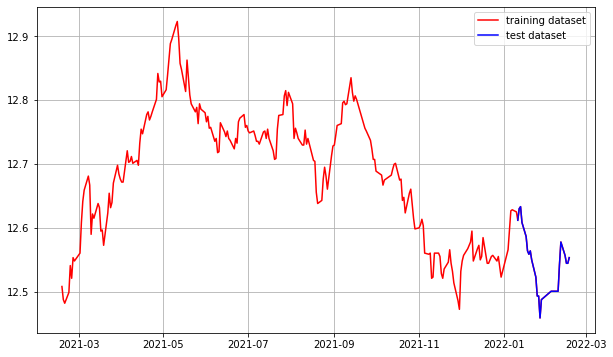

In [53]:
train_data_POSCO, test_data_POSCO = ts_POSCO_log[:int(len(ts_POSCO_log)*0.9)], ts_POSCO_log[int(len(ts_POSCO_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_POSCO_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_POSCO, c='b', label='test dataset')
plt.legend()

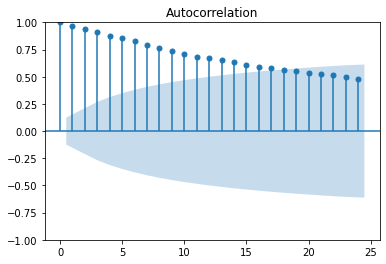

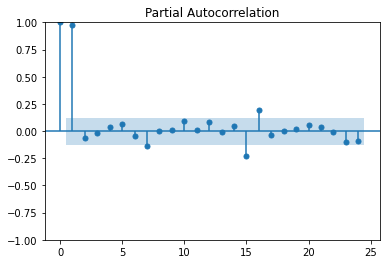

In [54]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_POSCO_log)   # ACF : Autocorrelation 그래프 그리기
#plot_acf(pd.Series(ts_KAKAO_log).diff(1).dropna())
plot_pacf(ts_POSCO_log)  # PACF : Partial Autocorrelation 그래프 그리기
#plot_pacf(pd.Series(ts_KAKAO_log).diff(1).dropna())
plt.show()

ACF는 조금씩 줄어들고, PACF는 1이후로 0의 값을 보인다. AR(1) 모델로 추정

Results of Dickey-Fuller Test:
Test Statistic                -1.536435e+01
p-value                        3.577497e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.744702e+00
p-value                        1.039433e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


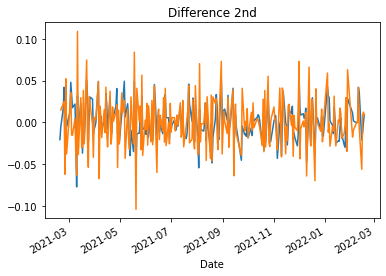

In [55]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1_POSCO = ts_POSCO_log.diff(periods=1).iloc[1:]
diff_1_POSCO.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_POSCO)

# 혹시 필요한 경우 2차 차분 구하기
diff_2_POSCO = diff_1_POSCO.diff(periods=1).iloc[1:]
diff_2_POSCO.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2_POSCO)

역시나 1차, 2차 미분에서 모두 안정된 모습을 보여주지만 2차 미분 선택

In [56]:
# Build Model
model_POSCO = ARIMA(train_data_POSCO, order=(1, 2, 0))  
fitted_m_POSCO = model_POSCO.fit() 

print(fitted_m_POSCO.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 483.399
Date:                Thu, 17 Feb 2022   AIC                           -962.798
Time:                        14:29:30   BIC                           -956.002
Sample:                             0   HQIC                          -960.054
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5017      0.058     -8.723      0.000      -0.614      -0.389
sigma2         0.0007   6.43e-05     11.452      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   5.74   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


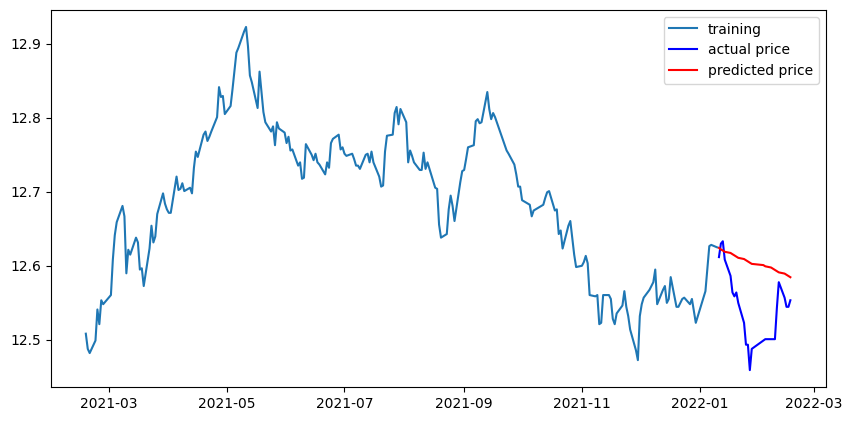

In [57]:
# Forecast : 결과가 fc에 담깁니다. 
fc_POSCO = fitted_m_POSCO.forecast(len(test_data_POSCO), alpha=0.05)  # 95% conf
fc_POSCO = np.array(fc_POSCO)
# Make as pandas series
fc_series_POSCO = pd.Series(fc_POSCO, index=test_data_POSCO.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_POSCO, label='training')
plt.plot(test_data_POSCO, c='b', label='actual price')
plt.plot(fc_series_POSCO, c='r',label='predicted price')
plt.legend()
plt.show()

급격한 하향 추세를 보이는 실제 데이터를 예측하지 못하고 완만한 하향 추세를 예측했다

In [58]:
mse_POSCO = mean_squared_error(np.exp(test_data_POSCO), np.exp(fc_POSCO))
print('MSE: ', mse_POSCO)

mae_POSCO = mean_absolute_error(np.exp(test_data_POSCO), np.exp(fc_POSCO))
print('MAE: ', mae_POSCO)

rmse_POSCO = math.sqrt(mean_squared_error(np.exp(test_data_POSCO), np.exp(fc_POSCO)))
print('RMSE: ', rmse_POSCO)

mape_POSCO = np.mean(np.abs(np.exp(fc_POSCO) - np.exp(test_data_POSCO))/np.abs(np.exp(test_data_POSCO)))
print('MAPE: {:.2f}%'.format(mape_POSCO*100))

MSE:  436153618.6320622
MAE:  17792.717385064556
RMSE:  20884.29119295319
MAPE: 6.53%


그래프에서도 꽤 차이가 있었듯이 MAPE가 6.53%로 낮지 않다.  
그럼에도 큰 값은 아니기에 의미가 있는것으로 보인다.

---

# 회고

(1) 코드를 따라하고 이해하기는 어렵지 않은 노드였다.  
그러나 이론 자체를 아직 다 이해하지 못했으며 이해하지 매우 어려운 노드였다.  
통계에 대해서는 이해를 잘 하고 있어야 앞으로도 무수한 데이터들을 상대할 때 유연하게 대처가 될 것이므로,  
시간이 조금 걸리더라도 이해하고 넘어가야겠다.

(2) p, d, q를 추정하는 부분에서 이해한대로 값을 선택하면 실제와 다르게 예측되는 경우가 많은데,  
모델의 잘못이라기 보다는 실제 데이터가 이전의 추세와는 다르게 흘러갔기 때문이라고 생각한다.  
결국, 주식과 같은 외부요인이 많은 데이터는 예측하는 것이 매우 어렵지 않을까 생각한다.